1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.stats import norm, linregress
from scipy.integrate import trapz
import pandas as pd
import seaborn as sn

In [2]:
np.random.seed(2087630)

In [3]:
N = 200
mean = 0
sd = 1
x = np.random.normal(mean, sd, N)

k = int(np.ceil(np.log2(N)) + 1)   #Sturges' formula(gaussian distribution for N ca. 100)

In [4]:
def generate_gaussians(x, std = 1.06*x.std()*x.size**(-0.2), n=500):
    """
    Create a gaussian for each value in x (vector) with mean x and std tunable.
    Return an (x.size, n) shape np.array whose each raw are the n values of each gaussian (this for eventual plot)
    and the corresponding arguments (common for each gaussian).
    """
    ans = np.ones((x.size, n))
    arguments = np.linspace(x.min()-3*std, x.max()+3*std, n)
    for i in range(x.size):
        for j in range(n):
            ans[i][j] = norm.pdf(arguments[j], loc=x[i], scale=std)
    return arguments, ans 

arguments, gaussians = generate_gaussians(x)

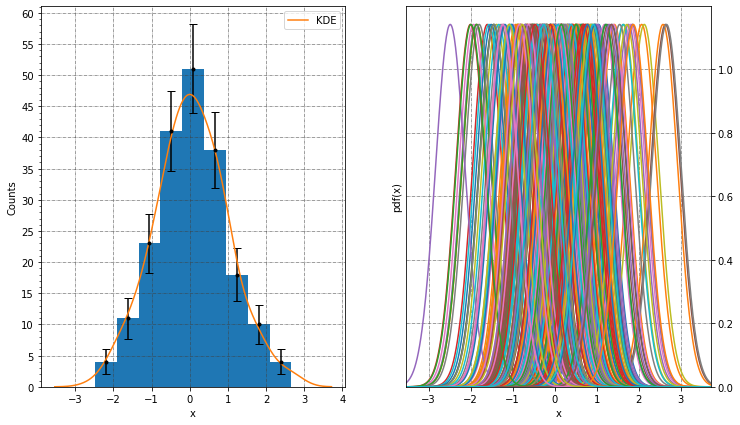

In [5]:
#https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width (rule of thumb)

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))

n, binedges, patches = ax1.hist(x, bins=k)

bin_size = binedges[1]-binedges[0]
bin_center_positions = [binedges[i] + bin_size/2 for i in range(len(binedges)-1)]

#now I have to evaluate the integral of the original histogram; call it I. Then, I have to multiply
#gaussians.sum(axis=0) (the sum of all the gaussians) for I, such that the two integrals,
#over the histogram and over the KDE, are equals.

n_for_integration = np.append(np.append(n[::-1], 0)[::-1],0)
bin_center_positions_for_int = np.append(bin_center_positions, binedges[k]+bin_size/2)
bin_center_positions_for_int = np.append(bin_center_positions_for_int[::-1], binedges[0]-bin_size/2)[::-1]

I = trapz(n_for_integration, bin_center_positions_for_int)

ax1.set_xlabel('x')
ax1.set_ylabel('Counts')
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.grid(linestyle="-.", linewidth=0.5, color='.25')

ax1.errorbar(bin_center_positions, n, yerr=np.sqrt(n), fmt='.k', linewidth=1.5, capsize=4)
   
for i in range(N):
    ax2.plot(arguments, gaussians[i])

ax2.set_xlabel('x')
ax2.set_ylabel('pdf(x)')
ax2.set_ylim(0)
std = 1.06*x.std()*x.size**(-0.2)
ax2.set_xlim(x.min()-3*std, x.max()+3*std)
ax2.yaxis.tick_right()
ax2.grid(linestyle="-.", linewidth=0.5, color='.25')
    
ax1.plot(arguments, gaussians.sum(axis=0)*I/N, label = "KDE")
ax1.legend()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

In [6]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
#from IPython.display import Image
#Image('two_categories_scatter_plot.png')

In [7]:
def twoD_dataset(N, n, means, stds, figsize, trasparency):
    """
    It generates a 2D datasets (of N data) of 2 categories. Each category is distribute as 
    a 2D gaussian with a given mean and std. It returns the dataset and the Axes object
    representig the scatter plot of the n distributions.
    """
    dim = 2
    ans = np.ones((N,n,dim))
    fig, ax = plt.subplots(figsize = (7,7))
    for j in range(n):
        ans[:,j,:] = np.random.normal(loc=means[j], scale=stds[j], size=(N,dim))
        ax.scatter(ans[:, j, 0], ans[:, j, 1], label = f'{j}', alpha = trasparency)
    return ans, ax

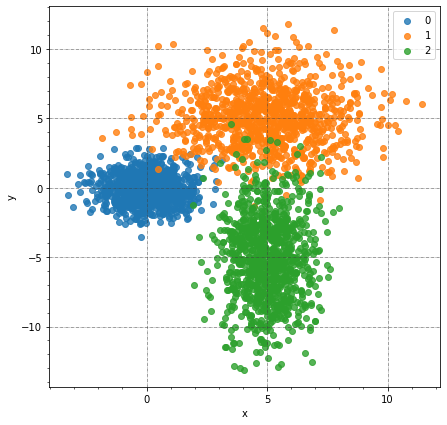

In [8]:
N = 1000
n = 3
means = ([0,0], [5,5], [5,-5])
stds = ([1,1], [2,2], [1, 3])

figsize = (7,7)
trasparency = 0.8

dataset, ax3 = twoD_dataset(N, n, means, stds, figsize, trasparency)

ax3.set_xlabel('x', fontsize=10)
ax3.set_ylabel('y', fontsize=10)
ax3.yaxis.set_major_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
ax3.xaxis.set_major_locator(MultipleLocator(5))
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.grid(linestyle="-.", linewidth=0.5, color='.25')
ax3.legend()

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [11]:
! wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

--2023-03-28 23:02:06--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [segue]
--2023-03-28 23:02:07--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc4f0b44cc1d8fd6e5802599603b.dl.dropboxusercontent.com/cd/0/inline/B5E92_peKqmRwv131h1tBgTntscc8OPzy-j1agqY1XpcRc5etZnMkwXTSa_lki7dhut2uK1gnpoVO2UnrWXQvOHmqrya81-RjxZyCU01pgpoU9iAeJySnjv6yQTIEUATaw7Z00vsQAr5qR_Dh6awpUo0SnLkNPLQW4aCMSurlpR5Xw/file# [segue]
--2023-03-28 23:02:08--  https://uc4f0b44cc1d8fd6e5802599603b.dl.dropboxusercontent.com/cd/0/inline/B5E92_peKqmRwv131h1tBgTntscc8OPzy-j1

In [12]:
data = pd.DataFrame(np.load('residuals_261.npy', allow_pickle=True).item())

In [13]:
data = data[np.abs(data['residuals']) <= 2 ]

#remove data with distances <=20
data = data[data['distances'] <=20]

In [14]:
res = data['residuals']
dist = data['distances']

reg = linregress(dist, res)

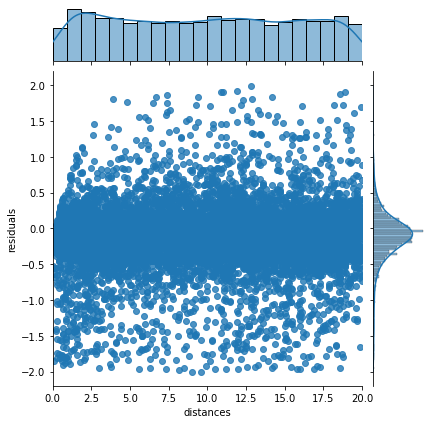

In [15]:
sn.jointplot(x='distances', y='residuals',data=data , kind='reg')

In [16]:
N = data['distances'].size
k = int(np.ceil(np.log2(N)) + 1)

In [17]:
pos_first_bin = 20/(2*k)
x = np.linspace(pos_first_bin, 20, k)

In [18]:
bins_width = x[1]-x[0]
y = np.ones(k)
erry = np.ones(k)
for i in range(k):
    slice_i = data[(data['distances']<x[i]+bins_width/2) & (data['distances']>=x[i]-bins_width/2)]['residuals']
    y[i] = slice_i.mean()
    erry[i] = slice_i.std()

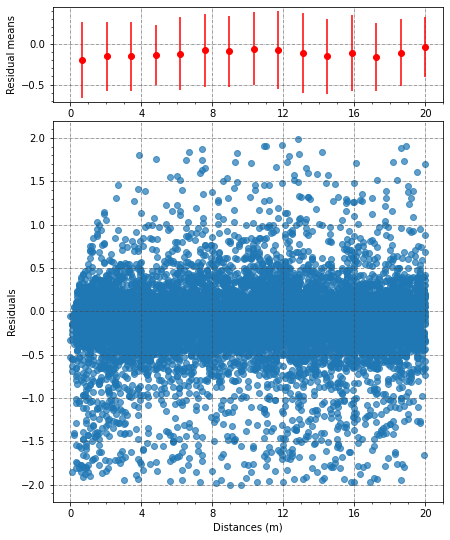

In [19]:
fig = plt.figure(figsize=(7,7))
ax = fig.subplots()
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)

ax.scatter(dist,res, alpha = 0.7)
ax.set_ylabel('Residuals')
ax.set_xlabel('Distances (m)')
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

ax_histx.errorbar(x,y,erry, fmt='o', color = 'red')
ax_histx.set_ylabel('Residual means')
ax_histx.yaxis.set_major_locator(MultipleLocator(0.5))
ax_histx.yaxis.set_minor_locator(AutoMinorLocator(5))
# ; to suppress the output!!

ax.grid(linestyle="-.", linewidth=0.5, color='.25')
ax_histx.grid(linestyle="-.", linewidth=0.5, color='.25')

plt.show()